Wir starten mit dem Import der benötigten Packages, dem Datenimport und einigen Preprocessing Schritten. Zum einen möchten wir zunächst nur die Informationen über die Anzahl der Fahrzeuge "NbCar", die zurückgelegte Distanz "distance_km", die Information über die Verfügbarkeit einer Jahreskarte "GenAbST" (1=vorhanden, 2=nicht vorhanden) und natürlich die Entscheidung "Choice" (0=öffentlich, 1=privat motorisiert, 2=unmotorisiert) berücksichtigen. Außerdem entfernen wir diejenigen Samples, die keine gültige Wahl angegeben haben und die Samples mit fehlenden Angaben.

In [1]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# read data
df_raw_data = pd.read_csv("optima.dat",'\t')

sample_size_raw_data = len(df_raw_data)
print("samples:", sample_size_raw_data, "\n")

# select columns
df_filtered = df_raw_data[['NbCar','distance_km','GenAbST','Choice']]

# only data with actual choice
df_filtered = df_filtered[df_filtered['Choice'].isin([0,1,2])]

# drop entries without response
df_filtered = df_filtered.replace({-1 : None})
df_filtered = df_filtered.dropna()
sample_size_filtered = len(df_filtered)

print('dropped %s%%' %np.round((sample_size_raw_data-sample_size_filtered)/sample_size_raw_data*100,1), "\n")

print("remaining samples:", sample_size_filtered, "\n")

print(df_filtered.head(), "\n")

print("proportion choices:")
print(df_filtered.Choice.value_counts(normalize=True))

samples: 2265 

dropped 20.2% 

remaining samples: 1807 

  NbCar  distance_km GenAbST Choice
0     1         30.0       1      1
3     1         25.0       2      1
4     2         12.5       2      1
5     2         19.0       2      1
6     1         13.0       2      1 

proportion choices:
1    0.661871
0    0.277809
2    0.060321
Name: Choice, dtype: float64


Der verbleibende Datensatz besteht also aus 1807 Samples, wobei sich diese entsprechend der angegebenen Prozente auf die verschiedenen Wahlmöglichkeiten aufteilen.

Bevor wir unser Random Forest Modell trainieren können, sind einige Schritte vorab zu tätigen. Wir müssen spezifizieren welche Daten das Modell nutzen soll, um welche anderen vorherzusagen, d.h. zu klassifizieren. Hier also soll der Random Forest anhand der verfügbaren Informationen die Wahl des Kunden vorhersagen. Die Spalte "Choice" enthält daher die abhängige Variable, die anderen Spalten die unabhängigen Variablen. Außerdem benötigen wir die Aufteilung in Trainingsdaten, auf denen wir das Modell lernen, und Testdaten, auf denen wir das Modell evaluieren.

In [2]:
# separation of data into independent and depent variables
X = df_filtered.drop(columns=['Choice'])
y = df_filtered[['Choice']].values.ravel() # 1-d-array expected
y = y.astype('int')

# separation of data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

print('samples training:', len(X_train), '\n')
print('samples test:', len(X_test))

# random forest model creation
rfc = RandomForestClassifier(n_estimators=10, max_depth = 2, bootstrap = False, random_state=1)
rfc.fit(X_train,y_train)

# predictions on test data
rfc_predict = rfc.predict(X_test)

samples training: 1210 

samples test: 597


Bevor wir uns über die Güte des Modells Gedanken machen, werfen wir erstmal einen Blick auf das Ergebnis. Eine sehr hilfreiches Package dafür ist graphviz. Einzelne Entscheidungsbäume können auf diese Weise visualisiert und als Bilddatei gespeichert werden.

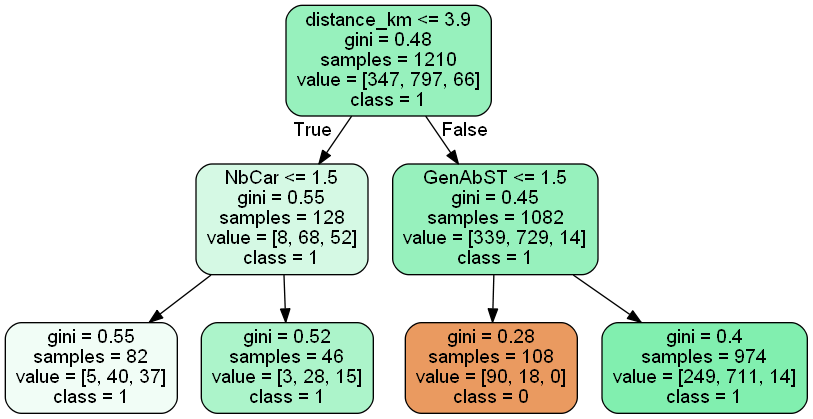

In [3]:
# import packages
from sklearn.tree import export_graphviz
import pydot

# choose one specific tree
tree = rfc.estimators_[0]

feature_list = list(X.columns)
class_list = ['0','1','2']

# export images to a dot file
export_graphviz(tree, out_file='tree_absolute.dot', 
                feature_names = feature_list,
                class_names = class_list,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

export_graphviz(tree, out_file='tree_proportion.dot', 
                feature_names = feature_list,
                class_names = class_list,
                rounded = True, proportion = True, 
                precision = 2, filled = True)

# use dot file to create a graph and write graph to a png file
(graph, ) = pydot.graph_from_dot_file('tree_absolute.dot')
graph.write_png('tree_absolute.png')

(graph, ) = pydot.graph_from_dot_file('tree_proportion.dot')
graph.write_png('tree_proportion.png')

# display
from IPython.display import Image
Image(filename = 'tree_absolute.png')

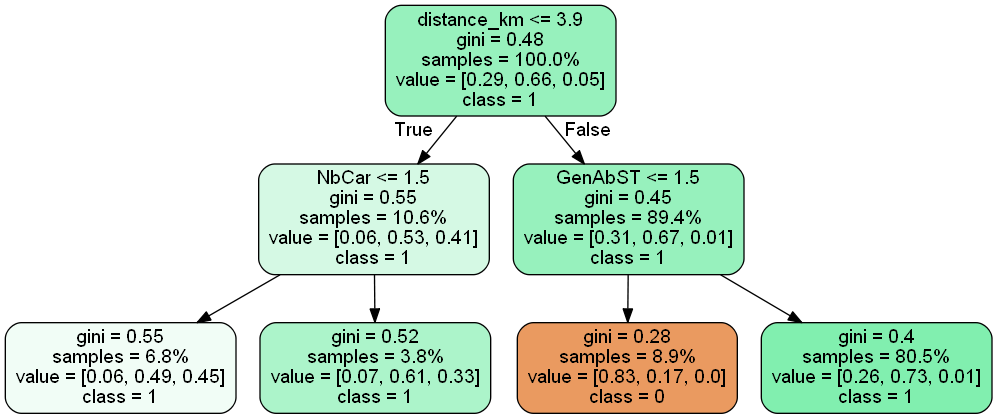

In [4]:
Image(filename = 'tree_proportion.png')

Während des Lernprozesses wurden 10 (n_estimators=10) Entscheidungsbäume in unserem Random Forest erstellt. Einen dieser Entscheidungsbäume sehen wir oben abgebildet, wobei sich die beiden Grafiken dadurch unterscheiden, dass oben einige Werte als asolute und unten als relative Werte angegeben werden. Was die veschiedenen Ausgaben bedeuten und wie ein solcher Entscheidungsbaum zu interpretieren ist, wollen wir uns nun anschauen.

Jeder Knoten, mit Ausnahme derer in der letzten Stufe, besitzt ein Kriterium, nach dem die Daten aufgeteilt werden. Im Wurzelknoten ist dies die Distanz, wobei alle Samples mit einer Distanz kleiner gleich 3.9km im linken Teilbaum und alle anderen im rechten zu finden sind. Für alle Knoten gilt die Logik, dass links diejenigen Daten sind, die das Kriterium erfüllen, und rechts die übrigen.

Der Wert "gini" steht für die sogenannte Gini Impurity. Dieser Wert gibt für den jeweiligen Knoten an wie wahrscheinlich es ist, dass ein zufällig gewähltes Sample falsch klassifiziert wird, wenn die Zuordnung anhand der Verteilung der Samples an diesem Knoten erfolgt. Das geprüfte Kriterium mit jeweiligem Schwellenwert wird nach und nach für jeden Knoten so gewählt, dass die auf jeder Stufe die größtmögliche Reduktion dieser Gini Impurity realisiert wird. Im Wurzelknoten wird also in etwas jedes zweite Sample falsch klassifiziert, wenn entsprechend der Verteilung in "value" gezogen wird. In dem orangenen Blatt ist diese Wahrscheinlichkeit bei nur 28%.

Die Information "samples" gibt die Anzahl bzw. den Anteil der Testdaten an, für die die bisherigen Kriterien im Baum erfüllt sind. Im Wurzelknoten sind sämtliche 1210 Trainingsdaten vorhanden. In der "value" Liste sind für diese Daten dann die tatsächlichen Entscheidungen für die drei Klassen, so wie sie in den Trainingsdaten vorlagen, aufgeführt. Unter den Daten mit mehr als 3.9km Distanz sind beispielsweise noch 339 Samples bei denen die Befragten angaben "öffentliche Verkehrsmittel" zu nutzen, 729 "Nutzer privater Kraftfahrzeuge" und 14 "Radfahrer bzw. Fußgänger".

Die Klassenbezeichnung "class" gibt an, welche der Klassen den Großteil der jeweiligen Teilmenge von Daten bildet.

Ein Sample mit 1km Distanz und 1 Fahrzeug pro Haushalt würde also in dem linksäußersten Blatt und damit der Klasse "1" zugeordnet werden. Dass diese Klassifikation aber keineswegs eindeutig ist kann man daran erkennen, dass nur 49% der Trainingsdaten mit diesen Kriterien tatsächlich zur Klasse "1" gehören, aber auch 45% zur Klasse "2". Andere Klassifikationen sind deutlich präziser, was auch durch die Farbgebung angedeutet wird und hier in dem organgenen Blatt zu erkennen ist.

Wie gut ist denn aber jetzt das gelernte Modell bzgl. der Prädiktionsgüte von unbekannten Samples? Einen Teil der Antwort liefert der Classification Report, denn er beantwortet die Frage, wieviele Samples der Testsdaten richtig klassifiziert werden.

In [11]:
from sklearn.metrics import classification_report
print('classification report:')
print(classification_report(y_test, rfc_predict))

classification report:
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       154
           1       0.78      0.93      0.85       377
           2       0.57      0.33      0.42        36

   micro avg       0.77      0.77      0.77       567
   macro avg       0.71      0.58      0.62       567
weighted avg       0.76      0.77      0.75       567



Zwei der Metriken, auf die wir uns an dieser Stelle beschränken wollen sind "precision" und "recall", wobei für beide Metriken gilt, dass die Prädiktion bei höherem Wert, der maximal 1 bzw. 100% betragen kann, besser war. Um diese zu verstehen, benötigen wir aber zunächst noch eine Unterscheidung zwischen den Möglichkeiten einer Klassifikation eines einzelnen Samples.

Samples, die einer bestimmten Klasse richtigerweise zugeordnet sind, d.h. bei der die tatsächliche und die vorhergesagte Klasse übereinstimmen, werden als "True Positive" (TP) bezeichnet. Diejenigen Samples, die einer bestimmten Klasse fälschlicherweise zugeordnet werden, bezeichnet man als "False Positive" (FP).

Wurde ein Sample richtigerweise einer Klasse nicht zugeordnet, so ist dies ein "True Negatve" (TN) Sample. Ein eigentlich zugehöriges Sample für eine bestimmte Klasse, welches aber fälschlicherweise als nichtzugehörig vorhergesagt wurde, ist eine "False Negative" (FN) Sample.

"Precision" gibt nun das Verhältnis TP/(TP+FP) an, also für die Klasse "0" beispielsweise, wieviele der Samples, die wir als "Nutzung der öffentlichen Verkehrsmittel" vorhergesagt haben (sowohl richtig als auch falsch), sind tatsächlich Nutzer dieser.

"Recall" ist das Verhältnis zwischen TP/(TP+FN), also für Klasse "2" beispielsweise, wieviele von den tatsächlichen Samples, die sich "nichtmotorisiert" fortbewegen (richtig klassifiziert und fälschlicherweise anders klassifiziert), haben wir richtig klassifiziert. Tatsächlich sind dies in unserem Fall 0%, was auch dadurch bestätigt wird, dass wir in den ursprünglichen Daten Samples mit "Choice=2" beobachtet haben, aber der Entscheidungsbaum kein Blatt mit dieser Klasse besitzt.

Was bedeutet also die obige Tabelle für unsere Modellgüte? Wenn wenn wir ein Sample als "0" oder "1" klassifiziert haben, so war dies auch in 84% bzw. 72% der Fälle korrekt. Vielleicht also gar nicht so schlech!?. Bezogen auf die tatsächlichen "0" Samples, haben wir aber nur 27% korrekt als solche klassifiziert, also sind viele auch falsch (hier dann zwingend als "1") klassifiziert worden. Die "1"er Samples wurde fast alle richtig als solche klassifiziert. Völlig versagt hat das Modell bei der Klassifikation der "2"er Samples, da nicht ein einziges richtig klassifiziert wurde.

Neben diesen hier beschriebenen klassenspezifischen Metriken gibt es darüber hinaus auch Kriterien, die allgemeine Aussagen über die Güte eines Random Forest zulassen. Zu nennen seien hier ROC und AUC, auf die ich aber auch an dieser Stelle nicht weiter eingehen möchte.

Stattdessen versuchen wir die Prädiktionen noch etwas zu verbessern, indem wir die Wichtigkeit der zur Verfügung stehenden Informationen analysieren. Dafür nehmen wir nun ein paar mehr Spalten aus dem Datensatz zur Hand, führen den Random Forest Algorithmus erneut durch und schauen dann auf die sogenannte Feature Importance.

In [6]:
# select columns
df_filtered = df_raw_data[['NbCar','distance_km','GenAbST','AreaRelST','UrbRur','TripPurpose','Income','Gender','Education','Choice']]

# only data with actual choice
df_filtered = df_filtered[df_filtered['Choice'].isin([0,1,2])]

# drop entries without response
df_filtered = df_filtered.replace({-1 : None})
df_filtered = df_filtered.dropna()
sample_size_filtered = len(df_filtered)

print("remaining samples:", sample_size_filtered, "\n")

remaining samples: 1582 



In [7]:
# separation of data into independent and depent variables
X = df_filtered.drop(columns=['Choice'])
y = df_filtered[['Choice']].values.ravel() # 1-d-array expected
y = y.astype('int')

feature_list = list(X.columns)
class_list = ['0','1','2']

# separation of data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

# random forest model creation
rfc = RandomForestClassifier(n_estimators=10, max_depth = 10, bootstrap = False, random_state=1)
rfc.fit(X_train,y_train)

# predictions on test data
rfc_predict = rfc.predict(X_test)

In [8]:
# get feature importances
importances = list(rfc.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: distance_km          Importance: 0.28
Variable: GenAbST              Importance: 0.22
Variable: NbCar                Importance: 0.14
Variable: AreaRelST            Importance: 0.12
Variable: Education            Importance: 0.08
Variable: Income               Importance: 0.06
Variable: TripPurpose          Importance: 0.05
Variable: UrbRur               Importance: 0.03
Variable: Gender               Importance: 0.03


Mit diesem Ergebnis, welches uns sagt, dass wir die drei wichtigsten Features bereits in unserem Modell oben berücksichtigt hatten, entscheiden wir uns die drei nächstwichtigen Features "AreaRelST", "UrbRur", "Income" ebenfalls noch hinzuzufügen. Außerdem limitieren wir die Tiefe bzw. die Stufen der Entscheidungsbäume nicht wie oben auf 3, sondern erlauben nun 10 Stufen mit "max_depth = 10".

In [9]:
# select columns
df_filtered = df_raw_data[['NbCar','distance_km','GenAbST','AreaRelST','UrbRur','Income','Choice']]

# only data with actual choice
df_filtered = df_filtered[df_filtered['Choice'].isin([0,1,2])]

# drop entries without response
df_filtered = df_filtered.replace({-1 : None})
df_filtered = df_filtered.dropna()
sample_size_filtered = len(df_filtered)

# separation of data into independent and depent variables
X = df_filtered.drop(columns=['Choice'])
y = df_filtered[['Choice']].values.ravel() # 1-d-array expected
y = y.astype('int')

feature_list = list(X.columns)
class_list = ['0','1','2']

# separation of data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

# random forest model creation
rfc = RandomForestClassifier(n_estimators=10, max_depth = 10, bootstrap = False, random_state=1)
rfc.fit(X_train,y_train)

# predictions on test data
rfc_predict = rfc.predict(X_test)

print('classification report:')
print(classification_report(y_test, rfc_predict))

classification report:
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       154
           1       0.78      0.93      0.85       377
           2       0.57      0.33      0.42        36

   micro avg       0.77      0.77      0.77       567
   macro avg       0.71      0.58      0.62       567
weighted avg       0.76      0.77      0.75       567



Mit Blick auf die vorhergesagten Klassifikationen ist das Modell nun insgesamt besser geworden. Zwar werden nun etwas weniger der "1" Samples korrekt klassifiziert (93% anstatt 98%) und auch die Precision sinkt bei Klasse "0" und "1" um einige Prozentpunkte, dafür kann bei Klasse "0" das Recall Gütekriterium von 27% auf 48% verbessert werden und auch die Samples der Klasse "2" können nun in 33% der Fälle korrekt vorhergesagt werden.

Zu guter Letzt bilden wir auch einen der erzeugten Entscheidungsbäume nochmal grafisch ab. Durch die Vielzahl an Entscheidungsknoten wird dieser Baum nun sehr unübersichtlich, auch wenn die einzelnen Entscheidungen zur Klassifikation nach wie vor einfach nachvollzogen werden können. 

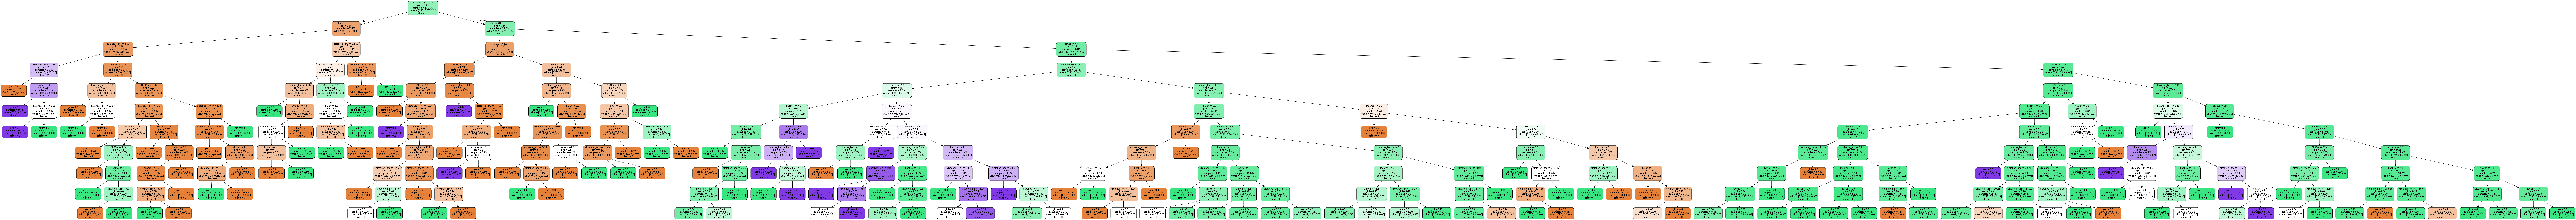

In [10]:
# choose one specific tree
tree = rfc.estimators_[0]

# export images to a dot file
export_graphviz(tree, out_file='tree_proportion_deep.dot', 
                feature_names = feature_list,
                class_names = class_list,
                rounded = True, proportion = True, 
                precision = 2, filled = True)

# use dot file to create a graph and write graph to a png file
(graph, ) = pydot.graph_from_dot_file('tree_proportion_deep.dot')
graph.write_png('tree_proportion_deep.png')

# display
from IPython.display import Image
Image(filename = 'tree_proportion_deep.png')